In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
import nltk
from nltk.corpus import stopwords


inputFile = "/content/drive/MyDrive/AI2/ergasia_1/imdb-reviews.csv"

# Insert the path of the file you want to test HERE
testFile = None

df = pd.read_csv(inputFile, sep='\t')

# Drop the first column (url)
df = df.drop(columns=['url'])

positive = 0
negative = 0
neutral = 0

# nltk.download('stopwords')

for index, row in df.iterrows():
    # if score is greater than 7, it is positive so change its value to 1, else 0
    if row["rating"] >= 7:
        positive += 1
        df.at[index, "rating"] = 1
    elif row["rating"] <= 4:
        negative += 1
        df.at[index, "rating"] = 0
    else:
        neutral += 1
    # To Remove the stop words uncomment the below line. Does not improve accuracy
    # df.at[index, "review"] = ' '.join([word for word in row["review"].split() if word not in (stopwords.words('english'))])

# Get the GloVe word embeddings
gloveFile = "glove.twitter.27B.200d.txt"

embeddings = {}
with open(gloveFile, 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings[word] = coefs

In [47]:
device = torch.device("cpu")

In [48]:
# Split the data into train 80% , test 10% and validation 10% sets

train = df.sample(frac=0.8, random_state=42)
test = df.drop(train.index)
test = test.sample(frac=0.5, random_state=42)
validation = df.drop(train.index)
validation = validation.drop(test.index)

if testFile is not None:
    test = pd.read_csv(testFile, sep='\t')
    test = test.drop(columns=['url'])

# print df, train, test, validation sizes
print("df size: ", df.shape)
print("train size: ", train.shape)
print("test size: ", test.shape)
print("validation size: ", validation.shape)

df size:  (45008, 2)
train size:  (36006, 2)
test size:  (4501, 2)
validation size:  (4501, 2)


In [49]:
# Get X_train, y_train, X_test, y_test, X_validation, y_validation
X_train = train["review"]
y_train = train["rating"]
X_test = test["review"]
y_test = test["rating"]
X_validation = validation["review"]
y_validation = validation["rating"]


# Create word vectors for train, test and validation sets
def createWordVectors(data):
  wordVectors = [];
  for row in data:
    sum = np.zeros(len(embeddings["hello"]));
    word_count = 0;
    for word in row.split():
      if word in embeddings:
        sum = sum + embeddings[word];
        word_count = word_count+1;
    if word_count != 0:
      wordVectors.append(sum/word_count);
    else:
      wordVectors.append(np.zeros(len(embeddings["hello"])))

  wordVectors = np.array(wordVectors, dtype=np.float32)
  return wordVectors


X_train = createWordVectors(X_train)
X_test = createWordVectors(X_test)
X_validation = createWordVectors(X_validation)

# Convert the word vectors from ndarrays to tensors
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
X_validation = torch.tensor(X_validation, dtype=torch.float)

# Convert the labels to tensors
y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)
y_validation = torch.tensor(y_validation.values, dtype=torch.float)


In [50]:
# The following classes regarding Attention, additiveAttention and multiplicativeAttention
# is developed by Tomek Korbak, PhD student, University of Sussex and can be
# found at the following link: 
# https://tomekkorbak.com/2020/06/26/implementing-attention-in-pytorch/


class Attention(torch.nn.Module):

    def __init__(self, encoder_dim: int, decoder_dim: int):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim

    def forward(self, 
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor, # [seq_length, encoder_dim]
        ):
        weights = self._get_weights(query, values) # [seq_length]
        weights = torch.nn.functional.softmax(weights, dim=0)
        return weights @ values  # [encoder_dim]


class AdditiveAttention(Attention):

    def __init__(self, encoder_dim, decoder_dim):
        super().__init__(encoder_dim, decoder_dim)
        self.v = torch.nn.Parameter(
            torch.FloatTensor(self.decoder_dim).uniform_(-0.1, 0.1))
        self.W_1 = torch.nn.Linear(self.decoder_dim, self.decoder_dim)
        self.W_2 = torch.nn.Linear(self.encoder_dim, self.decoder_dim)

    def _get_weights(self,        
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor,  # [seq_length, encoder_dim]
    ):
        query = query.repeat(values.size(0), 1)  # [seq_length, decoder_dim]
        weights = self.W_1(query) + self.W_2(values)  # [seq_length, decoder_dim]
        return torch.tanh(weights) @ self.v  # [seq_length]

class MultiplicativeAttention(Attention):

    def __init__(self, encoder_dim: int, decoder_dim: int):
        super().__init__(encoder_dim, decoder_dim)
        self.W = torch.nn.Parameter(torch.FloatTensor(
            self.decoder_dim, self.encoder_dim).uniform_(-0.1, 0.1))

    def _get_weights(self,
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor, # [seq_length, encoder_dim]
    ):
        weights = query @ self.W @ values.T  # [seq_length]
        return weights/np.sqrt(self.decoder_dim)  # [seq_length]

In [51]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional):
        super(Net, self).__init__()

        # batch_first=True causes input/output tensors to be of shape (batch, seq, feature), num_layers is the number of stacked RNNs
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        # self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.attention = AdditiveAttention(encoder_dim=hidden_size,decoder_dim=hidden_size)        
        self.dropout = nn.Dropout(0.2)

        if bidirectional:
            hidden_size = hidden_size * 2

        self.skip = nn.ModuleList([nn.Linear(input_size, hidden_size) for _ in range(num_layers)])
        self.relu = nn.ReLU()
        self.out = nn.Linear(hidden_size, output_size)
    
    # Forward pass that uses attention - Error crashes the kernel because it cannot allocate enough memory
    # def forward(self, x):
    #     # x shape: (batch, seq, feature)
    #     # r_out shape: (batch, time_step, output_size)
    #     # h_n shape: (n_layers, batch, hidden_size)
    #     # h_c shape: (n_layers, batch, hidden_size)
        
    #     # LSTM
    #     r_out, (h_n, h_c) = self.lstm(x, None)
    #     # GRU
    #     query = h_n.squeeze(0)
    #     attended_out = self.attention(query,r_out)

    #      # adding skip connections
    #     for i in range(len(self.skip)):
    #         attended_out += self.relu(self.skip[i](x).repeat(1,1,1))


    #     # dropout with predifined drop probability
    #     attended_out = self.dropout(attended_out)


    #     # choose r_out at the last time step
    #     out = self.out(attended_out[:, -1, :])

    #     return torch.sigmoid(out)

    def forward(self, x):
        # x shape: (batch, seq, feature)
        # r_out shape: (batch, time_step, output_size)
        # h_n shape: (n_layers, batch, hidden_size)
        # h_c shape: (n_layers, batch, hidden_size)
        
        # LSTM
        r_out, (h_n, h_c) = self.lstm(x, None)
        # GRU
        # r_out, h_n = self.gru(x, None)

        # adding skip connections
        for i in range(len(self.skip)):
            r_out += self.relu(self.skip[i](x))

        # dropout with predifined drop probability
        r_out = self.dropout(r_out)

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])

        return torch.sigmoid(out)



In [52]:
# Configure the model

input_size = 200
hidden_size = 200
num_layers = 2
output_size = 1
batch_size = 256
bidirectional = True

net = Net(input_size, hidden_size, num_layers, output_size, bidirectional)

EPOCH = 40
LR = 0.0005

optimizer = torch.optim.Adam(net.parameters(), lr=LR)  # optimize all net parameters
loss_func = nn.BCELoss()

# Initialize dataloader
dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [40]:
from torch.nn.utils import clip_grad_norm_


# Start training the model
net.train()

train_loss = []
val_loss = []

for epoch in range(EPOCH):

    batch_losses = []

    for step, (batch_x, batch_y) in enumerate(dataloader):
        
        # clear gradients for this training step
        optimizer.zero_grad()

        # reshape x to (batch, time_step, input_size)
        b_x = batch_x.view(-1, 1, 200)
        
        # batch y
        b_y = batch_y

        # rnn output
        output = net(b_x)
        # cross entropy loss
        loss = loss_func(output, b_y.unsqueeze(1))
        batch_losses.append(loss.item())
        # step += 1

        # backpropagation - compute gradients    
        loss.backward()
        nn.utils.clip_grad_value_(net.parameters(), 20)

        # apply gradients
        optimizer.step()                 

    with torch.no_grad():
      avg_batch_loss_train = sum(batch_losses)/len(batch_losses)
      train_loss.append(avg_batch_loss_train);
      Y_val_pred = net(X_validation.view(-1, 1, 200));
      loss_val = loss_func(Y_val_pred, y_validation.unsqueeze(-1))
      val_loss.append(loss_val.item());
    

    #print validation loss every epoch
    print('Epoch: ', epoch + 1, '| train loss: %.4f' % avg_batch_loss_train, '| val loss: %.4f' % loss_val.item())


Epoch:  1 | train loss: 0.5629 | val loss: 0.4542
Epoch:  2 | train loss: 0.4412 | val loss: 0.4433
Epoch:  3 | train loss: 0.4286 | val loss: 0.4226
Epoch:  4 | train loss: 0.4187 | val loss: 0.4128
Epoch:  5 | train loss: 0.4134 | val loss: 0.4105
Epoch:  6 | train loss: 0.4115 | val loss: 0.4182
Epoch:  7 | train loss: 0.4101 | val loss: 0.4143
Epoch:  8 | train loss: 0.4057 | val loss: 0.4124
Epoch:  9 | train loss: 0.4100 | val loss: 0.4123
Epoch:  10 | train loss: 0.4033 | val loss: 0.4224
Epoch:  11 | train loss: 0.4022 | val loss: 0.4058
Epoch:  12 | train loss: 0.4014 | val loss: 0.4009
Epoch:  13 | train loss: 0.3976 | val loss: 0.4102
Epoch:  14 | train loss: 0.3985 | val loss: 0.3988
Epoch:  15 | train loss: 0.3953 | val loss: 0.3984
Epoch:  16 | train loss: 0.3955 | val loss: 0.3992
Epoch:  17 | train loss: 0.3935 | val loss: 0.4009
Epoch:  18 | train loss: 0.3932 | val loss: 0.4053
Epoch:  19 | train loss: 0.3937 | val loss: 0.3987
Epoch:  20 | train loss: 0.3897 | val lo

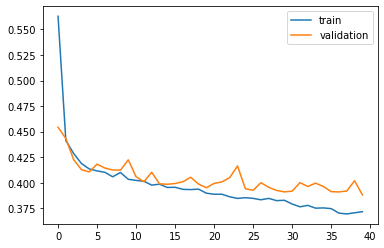

In [41]:
# Plot the learning curves for train and validation sets
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend()
plt.show()

In [42]:
# Calculate the precision, recall and f1 score
def calculate_metrics(y_true, y_pred):
    y_true = y_true.detach().numpy()
    y_pred = y_pred.detach().numpy()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

# Print the metrics for the train, test and validation sets
def print_metrics(y_true, y_pred, title):
    precision, recall, f1 = calculate_metrics(y_true, y_pred)
    print(f"{title:10} --> Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# Print the metrics for the train set
y_pred = net(X_train.view(-1, 1, 200))
print_metrics(y_train, y_pred, "Train")

# Print the metrics for the validation set
y_pred = net(X_validation.view(-1, 1, 200))
print_metrics(y_validation, y_pred, "Validation")

# Print the metrics for the test set
y_pred = net(X_test.view(-1, 1, 200))
print_metrics(y_test, y_pred, "Test")

Train      --> Precision: 0.842, Recall: 0.829, F1: 0.836
Validation --> Precision: 0.831, Recall: 0.819, F1: 0.825
Test       --> Precision: 0.844, Recall: 0.812, F1: 0.827


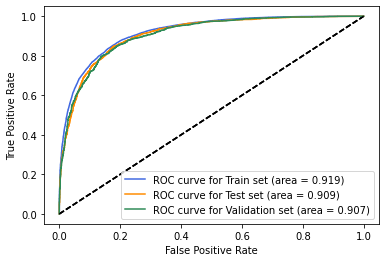

In [43]:
# Print ROC curves for train, test and validation sets on the same plot

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred, title, color):
    fpr, tpr, _ = roc_curve(y_true.detach(), y_pred.detach())
    plt.plot(fpr, tpr, label=f"ROC curve for {title} set (area = {auc(fpr, tpr):.3f})", color=color)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

# Plot the ROC curve for the train set
y_pred = net(X_train.view(-1, 1, 200))
plot_roc_curve(y_train, y_pred, "Train", "royalblue")

# Plot the ROC curve for the test set
y_pred = net(X_test.view(-1, 1, 200))
plot_roc_curve(y_test, y_pred, "Test", "darkorange")

# Plot the ROC curve for the validation set
y_pred = net(X_validation.view(-1, 1, 200))
plot_roc_curve(y_validation, y_pred, "Validation", "seagreen")

plt.show()